In [ ]:
! pip install -U sentence-transformers
! pip install datasets
! pip install tf_transformers
! pip install tensorflow_text
! pip install tf-models-official

In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from datasets import DatasetDict, Dataset
import tensorflow_hub as hub
import tensorflow as tf
import tensorflow_text as text
import numpy as np
from tqdm import tqdm
import numpy as np
from official.nlp import optimization
from sklearn.model_selection import train_test_split
from tensorflow_addons.optimizers import AdamW
from tensorflow import keras
from keras.api._v2.keras.backend import dtype
from keras.utils.np_utils import to_categorical
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score

In [3]:
! git clone https://github.com/phosseini/SentiPers

Cloning into 'SentiPers'...
remote: Enumerating objects: 424, done.
remote: Counting objects: 100% (424/424), done.
remote: Compressing objects: 100% (362/362), done.
remote: Total 424 (delta 105), reused 336 (delta 58), pack-reused 0
Receiving objects: 100% (424/424), 2.96 MiB | 8.68 MiB/s, done.
Resolving deltas: 100% (105/105), done.


In [4]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 10
num_epochs = 30

In [5]:
df = pd.read_excel('/content/SentiPers/data/sentipers.xlsx')

label_mapping = {-2: 0, -1: 1, 0: 2, 1: 3, 2: 4}
df["polarity"] = df["polarity"].map(label_mapping)

categorical_labels = to_categorical(df['polarity'], num_classes=5)

X_train, X_test_val, y_train, y_test_val = train_test_split(df, categorical_labels, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=0.5, shuffle=False)

In [6]:
X_train = tf.convert_to_tensor(list(X_train['text']), dtype=tf.string)
X_val = tf.convert_to_tensor(list(X_val['text']), dtype=tf.string)
X_test = tf.convert_to_tensor(list(X_test['text']), dtype=tf.string)

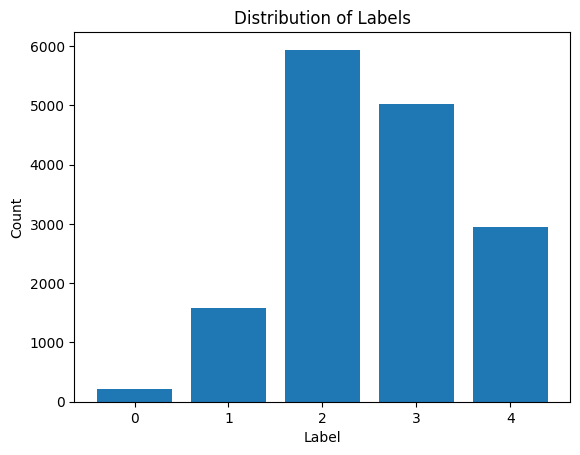

In [7]:
# Count the number of occurrences for each label
label_counts = df['polarity'].value_counts()

# Create a bar plot
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.show()

In [8]:
preprocessor = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2")
encoder = hub.KerasLayer("https://tfhub.dev/google/LaBSE/2")

In [9]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessing_layer = hub.KerasLayer(preprocessor, name='preprocessing')
encoder_inputs = preprocessing_layer(text_input)
encoder = hub.KerasLayer(encoder, name='LaBSE_encoder')
outputs = encoder(encoder_inputs)
net1 = outputs['pooled_output']
net2 = tf.keras.layers.Dropout(0.1)(net1)
out = tf.keras.layers.Dense(5, name='classifier', activation='softmax')(net2)

In [10]:
classifier_model = keras.Model(text_input, out)
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [11]:
step = tf.Variable(0, trainable=False)
schedule = tf.optimizers.schedules.PiecewiseConstantDecay(
 [1000], [5e-5,1e-5])
lr = 1 * schedule(step)
wd = lambda: 1e-6 * schedule(step)
optimizer=AdamW(learning_rate=lr,weight_decay=wd)

In [12]:
classifier_model.compile(loss="categorical_crossentropy",
 optimizer=optimizer,
 metrics=['accuracy'])

In [13]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [14]:
history_classifier = classifier_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=num_epochs, batch_size=batch_size, callbacks=[callback])

Epoch 1/30
393/393 [==============================] - 162s 382ms/step - loss: 1.4147 - accuracy: 0.3757 - val_loss: 1.3188 - val_accuracy: 0.4082
Epoch 2/30
393/393 [==============================] - 154s 392ms/step - loss: 1.2346 - accuracy: 0.4654 - val_loss: 1.2197 - val_accuracy: 0.4598
Epoch 3/30
393/393 [==============================] - 155s 394ms/step - loss: 1.1489 - accuracy: 0.5092 - val_loss: 1.1594 - val_accuracy: 0.5051
Epoch 4/30
393/393 [==============================] - 155s 395ms/step - loss: 1.0933 - accuracy: 0.5410 - val_loss: 1.1107 - val_accuracy: 0.5236
Epoch 5/30
393/393 [==============================] - 152s 386ms/step - loss: 1.0471 - accuracy: 0.5613 - val_loss: 1.0814 - val_accuracy: 0.5408
Epoch 6/30
393/393 [==============================] - 155s 394ms/step - loss: 1.0146 - accuracy: 0.5768 - val_loss: 1.0546 - val_accuracy: 0.5625
Epoch 7/30
393/393 [==============================] - 152s 386ms/step - loss: 0.9872 - accuracy: 0.5922 - val_loss: 1.0361 -

In [15]:
preds = classifier_model.predict(X_test)
class_preds = np.argmax(preds, axis=1)

50/50 [==============================] - 17s 335ms/step


In [16]:
acc = accuracy_score(class_preds, np.argmax(y_test, axis=1))
print("Accuracy on test data: " + str(acc))

Accuracy on test data: 0.6246016571064372


In [17]:
prc = precision_score(class_preds, np.argmax(y_test, axis=1), average='micro')
print("Precision on test data: " + str(prc))

Precision on test data: 0.6246016571064372


In [18]:
rcl = recall_score(class_preds, np.argmax(y_test, axis=1), average='micro')
print("Recall on test data: " + str(rcl))

Recall on test data: 0.6246016571064372


In [19]:
f1 = f1_score(class_preds, np.argmax(y_test, axis=1), average='micro')
print("F1 on test data: " + str(f1))

F1 on test data: 0.6246016571064372


In [20]:
cnf = confusion_matrix(class_preds, np.argmax(y_test, axis=1))
print("Confusion Matrix for test data:")
print(cnf)

Confusion Matrix for test data:
[[  0   1   0   0   0]
 [  6  61  23  16   4]
 [  6  39 447 181  15]
 [  4  22  73 300  84]
 [  2   4   7 102 172]]


In [21]:
snapfood_df = pd.read_csv('snapfood_testset.csv')

In [22]:
label_mapping = {"SAD": 0, "HAPPY": 1}

snapfood_df["label"] = snapfood_df["label"].map(label_mapping)

In [23]:
snappfood_tensor = tf.convert_to_tensor(list(snapfood_df['comment']), dtype=tf.string)

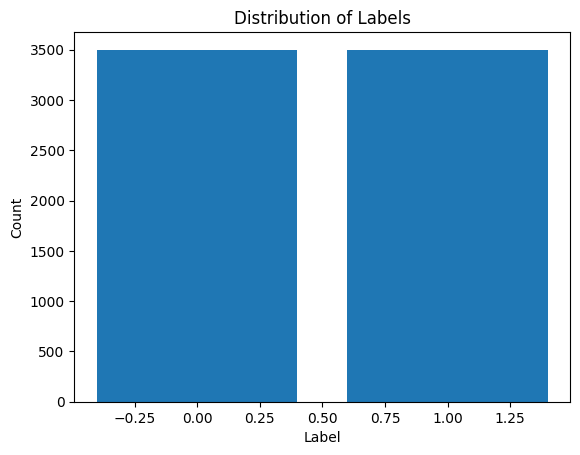

In [24]:
# Count the number of occurrences for each label
label_counts = snapfood_df['label'].value_counts()

# Create a bar plot
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.show()

In [25]:
snapfood_preds = classifier_model.predict(snappfood_tensor)
snapfood_class_preds = np.argmax(snapfood_preds, axis=1)

219/219 [==============================] - 74s 339ms/step


In [26]:
transformed_labels = [0 if val in [0, 1] else 1 for val in snapfood_class_preds]

In [27]:
acc_snapfood = accuracy_score(transformed_labels, snapfood_df["label"].tolist())
print("Accuracy on test data: " + str(acc_snapfood))

Accuracy on test data: 0.6964285714285714


In [28]:
prc_snapfood = precision_score(transformed_labels, snapfood_df["label"].tolist(), average='micro')
print("Precision on test data: " + str(prc_snapfood))

Precision on test data: 0.6964285714285714


In [29]:
rcl_snapfood = recall_score(transformed_labels, snapfood_df["label"].tolist(), average='micro')
print("Recall on test data: " + str(rcl_snapfood))

Recall on test data: 0.6964285714285714


In [30]:
f1_snapfood = f1_score(transformed_labels, snapfood_df["label"].tolist(), average='micro')
print("F1 on test data: " + str(f1_snapfood))

F1 on test data: 0.6964285714285714


In [31]:
cnf_snapfood = confusion_matrix(transformed_labels, snapfood_df["label"].tolist())
print("Confusion Matrix for snapfood data:")
print(cnf_snapfood)

Confusion Matrix for snapfood data:
[[1838  463]
 [1662 3037]]
